In [ ]:
import torch
import torch.nn as nn

# here we are testing to see if we can set up a base model in the correct
#format for ResNet 18 to attempt a transfer learning approach to the model

class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(planes)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        )

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=(1, 2, 2))
        self.layer3 = self._make_layer(block, 256, layers[2], stride=(1, 2, 2))
        self.layer4 = self._make_layer(block, 512, layers[3], stride=(1, 2, 2))

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

def r3d_18(pretrained=False, num_classes=400, **kwargs): # originally the number of ouptuts classes are 400
    model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=num_classes, **kwargs)
    return model

# here is the downloaded .pth for the resnet 18
#found the model on kaggle
pretrained_weights_path = 'r3d_18-b3b3357e.pth'

# creating the model with 400 classes 
model = r3d_18(num_classes=400) # instantiate with the output size from the pre-trained model

# loading state dictionary from .pthfile
try:
    pretrained_dict = torch.load(pretrained_weights_path)
    model.load_state_dict(pretrained_dict)
    print(f"Successfully loaded pre-trained weights from: {pretrained_weights_path}")

    #  weights are loaded

except FileNotFoundError:
    print(f"Error: Pre-trained weights file not found at {pretrained_weights_path}")
except RuntimeError as e:
    print(f"Error loading state dict: {e}")
    print("Please investigate the model architecture to ensure it matches the weights.")

C:\Users\Scooter\AppData\Local\Temp\ipykernel_17116\3013335091.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(pretrained_weights_path)


Successfully loaded pre-trained weights from: r3d_18-b3b3357e.pth


In [ ]:
import torch.nn as nn

# Get the number of input features of the original fc layer
in_features = model.fc.in_features

# Create a new Linear layer with the correct output size (10 classes)
num_classes = 10
new_fc = nn.Linear(in_features, num_classes)

# Replace the old fc layer with the new one
model.fc = new_fc

print(model.fc)

#so here we changed the last fully connected layer to go to 10 outputs instead
# of 400

Linear(in_features=512, out_features=10, bias=True)


In [ ]:
import torch

#check for GPU
if torch.cuda.is_available():
    # Get the name of the primary GPU
    gpu_name = torch.cuda.get_device_name(0)
    print(f"CUDA is available. Using GPU: {gpu_name}")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

#num of available GPUS
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

CUDA is available. Using GPU: NVIDIA GeForce GTX 1050 Ti
Number of GPUs available: 1


In [1]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())

12.1
True


Processing 4260 video annotations...
Class distribution:
Class 0: 426 samples
Class 1: 426 samples
Class 2: 426 samples
Class 3: 426 samples
Class 4: 426 samples
Class 5: 426 samples
Class 6: 426 samples
Class 7: 426 samples
Class 8: 426 samples
Class 9: 426 samples
Creating video dataset...
Total dataset size: 4260
Training set size: 3408
Validation set size: 852
Number of classes: 10
Loading pretrained R3D-18 model...


C:\Users\Scooter\AppData\Local\Temp\ipykernel_17116\1641297685.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(pretrained_path, map_locati

Successfully loaded pre-trained weights from: r3d_18-b3b3357e.pth
Creating transfer learning model...

Model Architecture:
TransferLearningVideoClassifier(
  (base_model): ResNet3D(
    (stem): Sequential(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): BasicBlock3D(
        (conv1): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        

Evaluating: 100%|██████████| 213/213 [01:04<00:00,  3.28it/s]


Epoch 1/15:
  Train Loss: 2.0210, Train Acc: 0.2793
  Val Loss: 1.6248, Val Acc: 0.4272
  Learning rate: 0.000100


Evaluating: 100%|██████████| 213/213 [01:04<00:00,  3.31it/s]


Epoch 2/15:
  Train Loss: 1.6490, Train Acc: 0.4393
  Val Loss: 1.4985, Val Acc: 0.5117
  Learning rate: 0.000100


Evaluating: 100%|██████████| 213/213 [01:08<00:00,  3.09it/s]


Epoch 3/15:
  Train Loss: 1.3087, Train Acc: 0.5681
  Val Loss: 1.4325, Val Acc: 0.5540
  Learning rate: 0.000100


Evaluating: 100%|██████████| 213/213 [01:00<00:00,  3.50it/s]


Epoch 4/15:
  Train Loss: 0.9242, Train Acc: 0.6966
  Val Loss: 1.5906, Val Acc: 0.5411
  Learning rate: 0.000100


Evaluating: 100%|██████████| 213/213 [01:00<00:00,  3.51it/s]


Epoch 5/15:
  Train Loss: 0.6646, Train Acc: 0.7899
  Val Loss: 1.6691, Val Acc: 0.5739
  Learning rate: 0.000100


Evaluating: 100%|██████████| 213/213 [01:02<00:00,  3.40it/s]


Epoch 6/15:
  Train Loss: 0.5072, Train Acc: 0.8489
  Val Loss: 1.8635, Val Acc: 0.5282
  Learning rate: 0.000050


Evaluating: 100%|██████████| 213/213 [01:01<00:00,  3.45it/s]


Epoch 7/15:
  Train Loss: 0.3283, Train Acc: 0.9023
  Val Loss: 1.6520, Val Acc: 0.5845
  Learning rate: 0.000050


Evaluating: 100%|██████████| 213/213 [01:05<00:00,  3.27it/s]


Epoch 8/15:
  Train Loss: 0.2583, Train Acc: 0.9234
  Val Loss: 1.7078, Val Acc: 0.5775
  Learning rate: 0.000050


Evaluating: 100%|██████████| 213/213 [01:11<00:00,  2.98it/s]


Epoch 9/15:
  Train Loss: 0.2125, Train Acc: 0.9396
  Val Loss: 1.6537, Val Acc: 0.5798
  Learning rate: 0.000025


Evaluating: 100%|██████████| 213/213 [01:01<00:00,  3.44it/s]


Epoch 10/15:
  Train Loss: 0.1638, Train Acc: 0.9548
  Val Loss: 1.6919, Val Acc: 0.5845
  Learning rate: 0.000025


Evaluating: 100%|██████████| 213/213 [00:59<00:00,  3.57it/s]


Epoch 11/15:
  Train Loss: 0.1575, Train Acc: 0.9563
  Val Loss: 1.5951, Val Acc: 0.5904
  Learning rate: 0.000025


Evaluating: 100%|██████████| 213/213 [01:02<00:00,  3.39it/s]


Epoch 12/15:
  Train Loss: 0.1096, Train Acc: 0.9698
  Val Loss: 1.6174, Val Acc: 0.5951
  Learning rate: 0.000013


Evaluating: 100%|██████████| 213/213 [01:01<00:00,  3.48it/s]


Epoch 13/15:
  Train Loss: 0.1023, Train Acc: 0.9724
  Val Loss: 1.5896, Val Acc: 0.6115
  Learning rate: 0.000013


Evaluating: 100%|██████████| 213/213 [01:02<00:00,  3.38it/s]


Epoch 14/15:
  Train Loss: 0.0840, Train Acc: 0.9798
  Val Loss: 1.6529, Val Acc: 0.6080
  Learning rate: 0.000013


Evaluating: 100%|██████████| 213/213 [01:01<00:00,  3.47it/s]


Epoch 15/15:
  Train Loss: 0.0832, Train Acc: 0.9795
  Val Loss: 1.6014, Val Acc: 0.6009
  Learning rate: 0.000006
Loaded best model with validation accuracy: 0.6115


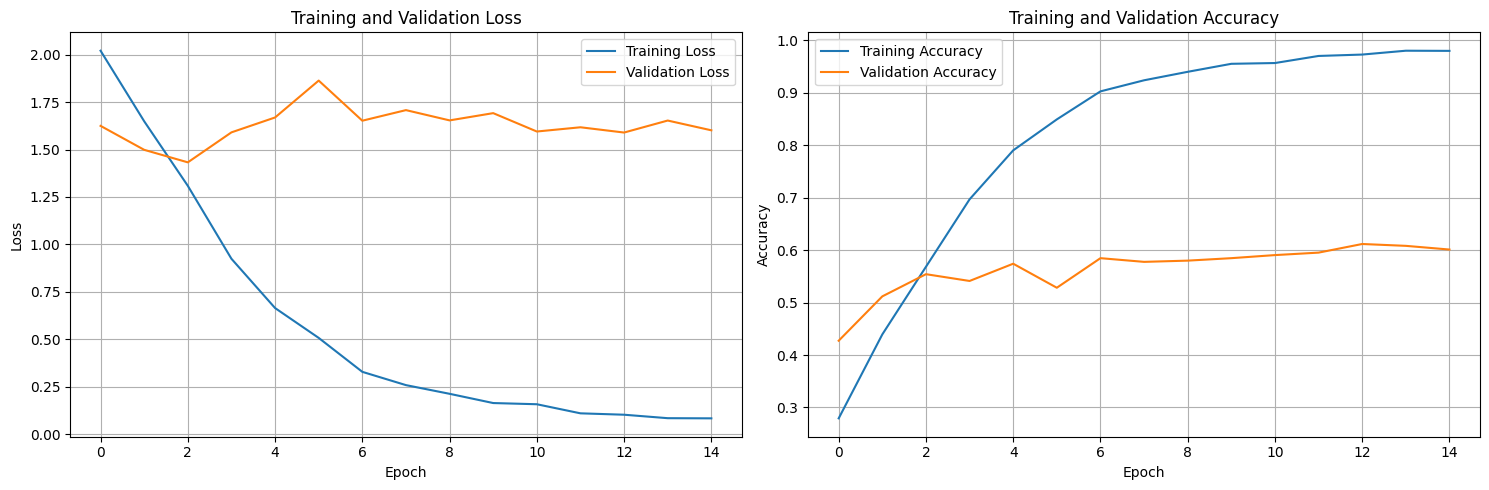


Final evaluation on validation set:


Testing: 100%|██████████| 213/213 [01:01<00:00,  3.47it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        90
           1       0.61      0.55      0.58        83
           2       0.66      0.63      0.65        93
           3       0.75      0.60      0.67        91
           4       0.72      0.85      0.78        68
           5       0.45      0.46      0.45        81
           6       0.57      0.43      0.49        96
           7       0.60      0.80      0.69        84
           8       0.57      0.54      0.55        85
           9       0.47      0.53      0.50        81

    accuracy                           0.60       852
   macro avg       0.60      0.61      0.60       852
weighted avg       0.60      0.60      0.60       852



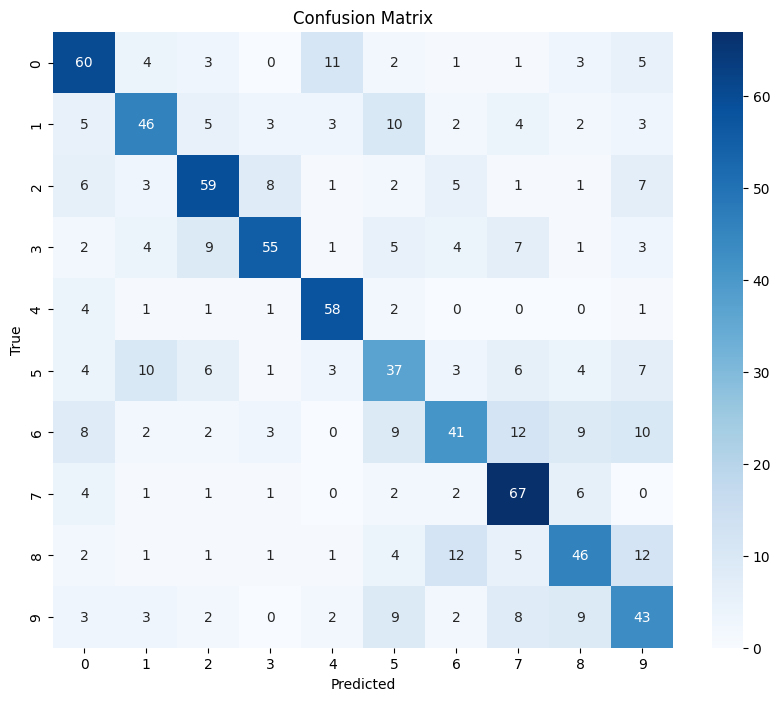

Validation accuracy: 0.6009
Model saved to video_classifier_transfer_learning.pth


In [ ]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gc

# file paths
mp4_directory = "archive/downsampled_data"
json_file_path = "archive/downsampled_annotations.json"

# parameters from your original model
target_resolution = (112, 80)  # reduced resolution
num_frames = 16  # number of frames to extract per video
batch_size = 4  

# basic Block for ResNet3D
class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(planes)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# resNet3D model
class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        )

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=(1, 2, 2))
        self.layer3 = self._make_layer(block, 256, layers[2], stride=(1, 2, 2))
        self.layer4 = self._make_layer(block, 512, layers[3], stride=(1, 2, 2))

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.stem(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def r3d_18(pretrained=False, pretrained_path=None, num_classes=400, **kwargs):
    model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=num_classes, **kwargs)
    
    if pretrained and pretrained_path:
        try:
            pretrained_dict = torch.load(pretrained_path, map_location=torch.device('cpu'))
            model.load_state_dict(pretrained_dict)
            print(f"Successfully loaded pre-trained weights from: {pretrained_path}")
        except FileNotFoundError:
            print(f"Error: Pre-trained weights file not found at {pretrained_path}")
        except RuntimeError as e:
            print(f"Error loading state dict: {e}")
            print("Please investigate the model architecture to ensure it matches the weights.")
    
    return model

# videoDataset class
class VideoDataset(Dataset):
    """Custom dataset for video classification that loads videos on-the-fly"""
    
    def __init__(self, video_paths, labels, num_frames=16, target_resolution=(112, 80), transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.target_resolution = target_resolution
        self.transform = transform
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        # extract frames from video
        frames = self.extract_video_frames(video_path)
        
        # if frames could not be extracted, return a dummy tensor with zeros
        if frames is None:
            dummy_frames = np.zeros((self.num_frames, self.target_resolution[1], self.target_resolution[0], 3), dtype=np.uint8)
            frames_tensor = torch.tensor(dummy_frames, dtype=torch.float32).permute(3, 0, 1, 2) / 255.0
            return frames_tensor, label
        
        frames_tensor = torch.tensor(np.array(frames), dtype=torch.float32).permute(3, 0, 1, 2) / 255.0
        
        # apply any transformations if specified
        if self.transform:
            frames_tensor = self.transform(frames_tensor)
        
        return frames_tensor, label
    
    def extract_video_frames(self, video_path, max_frames=None):
        """Extract frames from a video file"""
        if max_frames is None:
            max_frames = self.num_frames
            
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error opening video {video_path}")
                return None
            
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames == 0:
                print(f"Error: video {video_path} has zero frames")
                return None
                
            # adjust number of frames to extract based on actual video length
            num_frames_to_extract = min(max_frames, total_frames)
            frame_indices = np.linspace(0, total_frames - 1, num_frames_to_extract, dtype=int)
            
            for i in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret:
                    print(f"Error: Could not read frame {i} from {video_path}")
                    cap.release()
                    return None
                
                # resize frame to match the pretrained model's expected input size
                frame = cv2.resize(frame, self.target_resolution)
                frames.append(frame)
                
            cap.release()
            return frames
            
        except Exception as e:
            print(f"Exception processing {video_path}: {e}")
            return None

# load data function
def prepare_data():
    """Load annotations and prepare paths and labels for creating datasets"""
    try:
        with open(json_file_path, "r") as f:
            annotations = json.load(f)
    except Exception as e:
        print(f"Error loading annotations: {e}")
        return None, None, None
    
    video_paths = []
    labels = []
    video_ids = []
    
    print(f"Processing {len(annotations)} video annotations...")
    
    for video_id, label in annotations.items():
        video_path = os.path.join(mp4_directory, video_id + ".mp4")
        if os.path.exists(video_path):
            video_paths.append(video_path)
            labels.append(label)
            video_ids.append(video_id)
    
    # get class distribution
    unique_classes, counts = np.unique(labels, return_counts=True)
    print("Class distribution:")
    for cls, count in zip(unique_classes, counts):
        print(f"Class {cls}: {count} samples")
    
    return video_paths, labels, video_ids

# transfer learning model
class TransferLearningVideoClassifier(nn.Module):
    def __init__(self, base_model, num_classes=10, freeze_base=True):
        super(TransferLearningVideoClassifier, self).__init__()
        
        # use the base model without the final fully connected layer
        self.base_model = base_model
        
        # replace the final fully-connected layer
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()  # remove the original fc layer
        
        # add our custom classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        # freeze base model weights if requested
        if freeze_base:
            for param in self.base_model.parameters():
                param.requires_grad = False
            
            # unfreeze the last convolutional layer (fine-tuning)
            for param in self.base_model.layer4.parameters():
                param.requires_grad = True
    
    def forward(self, x):
        # pass through the base CNN
        features = self.base_model(x)
        # pass through our custom classifier
        return self.classifier(features)

# training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001):
    """Train the model with memory-efficient processing"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    # use different learning rates for different parts of the model
    params_to_update = []
    
    # check which parameters require gradients
    update_params_name = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            update_params_name.append(name)
    
    print(f"Parameters being updated: {update_params_name}")
    
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    # for tracking metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # frward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # clear GPU
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # validation phase
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # learning rate scheduler step
        scheduler.step(val_loss)
        
        # save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_accuracy:.4f}")
    
    # plot training curves
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return model

# evaluation function
def evaluate_model(model, data_loader, criterion=None, device=None):
    """Evaluate model on the provided data loader"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # free memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

# testing function
def test_model_detailed(model, test_loader, class_names=None):
    """Perform detailed testing with metrics and confusion matrix"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            
            # free memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    # calculate and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # generate classification report
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(all_labels)))]
    
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    
    # plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # return overall accuracy
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    return accuracy

# visualizatoin function
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation metrics"""
    # create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.savefig('training_curves.png')
    plt.tight_layout()
    plt.show()

# saves model
def save_model(model, filename='video_classifier_transfer_learning.pth'):
    """Save the trained model to disk"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': str(model),
    }, filename)
    print(f"Model saved to {filename}")

if __name__ == "__main__":
    # set the path to the pre-trained weights
    pretrained_weights_path = 'r3d_18-b3b3357e.pth'
    
    # prepare data paths and labels
    video_paths, labels, video_ids = prepare_data()
    
    if not video_paths:
        print("Failed to prepare data. Exiting.")
        exit(1)
    
    # create dataset
    print("Creating video dataset...")
    dataset = VideoDataset(video_paths, labels, num_frames=num_frames, target_resolution=target_resolution)
    
    # split dataset
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    print(f"Total dataset size: {dataset_size}")
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {val_size}")
    
    # create data loaders with small batch size to save memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # count number of classes
    num_classes = len(np.unique(labels))
    print(f"Number of classes: {num_classes}")
    
    # load pretrained model
    print("Loading pretrained R3D-18 model...")
    base_model = r3d_18(pretrained=True, pretrained_path=pretrained_weights_path, num_classes=400)
    
    # create the transfer learning model
    print("Creating transfer learning model...")
    model = TransferLearningVideoClassifier(base_model, num_classes=num_classes, freeze_base=True)
    
    # print model architecture summary
    print("\nModel Architecture:")
    print(model)
    
    # count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTrainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")
    
    # train model
    print("\nStarting training...")
    model = train_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.0001)
    
    # final evaluation on validation set
    print("\nFinal evaluation on validation set:")
    class_names = [str(i) for i in range(num_classes)]
    val_accuracy = test_model_detailed(model, val_loader, class_names)
    print(f"Validation accuracy: {val_accuracy:.4f}")
    
    # save the model
    save_model(model)

Processing 4260 video annotations...
Class distribution:
Class 0: 426 samples
Class 1: 426 samples
Class 2: 426 samples
Class 3: 426 samples
Class 4: 426 samples
Class 5: 426 samples
Class 6: 426 samples
Class 7: 426 samples
Class 8: 426 samples
Class 9: 426 samples
Creating video dataset...
Total dataset size: 4260
Training set size: 3408
Validation set size: 852
Number of classes: 10
Loading pretrained R3D-18 model...


C:\Users\Scooter\AppData\Local\Temp\ipykernel_17116\2607630561.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(pretrained_path, map_locati

Successfully loaded pre-trained weights from: r3d_18-b3b3357e.pth
Creating transfer learning model with frozen convolutional layers...

Model Architecture:
TransferLearningVideoClassifier(
  (base_model): ResNet3D(
    (stem): Sequential(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): BasicBlock3D(
        (conv1): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

Evaluating: 100%|██████████| 107/107 [01:00<00:00,  1.77it/s]


Epoch 1/20:
  Train Loss: 2.1817, Train Acc: 0.2163
  Val Loss: 1.9333, Val Acc: 0.3110
  Learning rate: 0.000994


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.82it/s]


Epoch 2/20:
  Train Loss: 1.9917, Train Acc: 0.2861
  Val Loss: 1.9094, Val Acc: 0.3204
  Learning rate: 0.000976


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.82it/s]


Epoch 3/20:
  Train Loss: 1.9116, Train Acc: 0.3254
  Val Loss: 1.8586, Val Acc: 0.3462
  Learning rate: 0.000946


Evaluating: 100%|██████████| 107/107 [01:05<00:00,  1.63it/s]


Epoch 4/20:
  Train Loss: 1.8470, Train Acc: 0.3515
  Val Loss: 1.8484, Val Acc: 0.3439
  Learning rate: 0.000905


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.79it/s]


Epoch 5/20:
  Train Loss: 1.8241, Train Acc: 0.3527
  Val Loss: 1.8311, Val Acc: 0.3509
  Learning rate: 0.000854


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.82it/s]


Epoch 6/20:
  Train Loss: 1.7749, Train Acc: 0.3800
  Val Loss: 1.8082, Val Acc: 0.3756
  Learning rate: 0.000794


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.80it/s]


Epoch 7/20:
  Train Loss: 1.7440, Train Acc: 0.3882
  Val Loss: 1.8278, Val Acc: 0.3486
  Learning rate: 0.000727


Evaluating: 100%|██████████| 107/107 [01:01<00:00,  1.73it/s]


Epoch 8/20:
  Train Loss: 1.7107, Train Acc: 0.4023
  Val Loss: 1.8091, Val Acc: 0.3732
  Learning rate: 0.000655


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.80it/s]


Epoch 9/20:
  Train Loss: 1.6625, Train Acc: 0.4117
  Val Loss: 1.7895, Val Acc: 0.3685
  Learning rate: 0.000578


Evaluating: 100%|██████████| 107/107 [01:07<00:00,  1.60it/s]


Epoch 10/20:
  Train Loss: 1.6538, Train Acc: 0.4193
  Val Loss: 1.8032, Val Acc: 0.3709
  Learning rate: 0.000500


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.83it/s]


Epoch 11/20:
  Train Loss: 1.6389, Train Acc: 0.4310
  Val Loss: 1.7750, Val Acc: 0.3838
  Learning rate: 0.000422


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.84it/s]


Epoch 12/20:
  Train Loss: 1.5822, Train Acc: 0.4583
  Val Loss: 1.7999, Val Acc: 0.3885
  Learning rate: 0.000345


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.82it/s]


Epoch 13/20:
  Train Loss: 1.5629, Train Acc: 0.4583
  Val Loss: 1.7840, Val Acc: 0.3791
  Learning rate: 0.000273


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.79it/s]


Epoch 14/20:
  Train Loss: 1.5135, Train Acc: 0.4707
  Val Loss: 1.7669, Val Acc: 0.3862
  Learning rate: 0.000206


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.82it/s]


Epoch 15/20:
  Train Loss: 1.4986, Train Acc: 0.4786
  Val Loss: 1.7807, Val Acc: 0.3979
  Learning rate: 0.000146


Evaluating: 100%|██████████| 107/107 [00:58<00:00,  1.83it/s]


Epoch 16/20:
  Train Loss: 1.4577, Train Acc: 0.4985
  Val Loss: 1.7914, Val Acc: 0.3768
  Learning rate: 0.000095


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.81it/s]


Epoch 17/20:
  Train Loss: 1.4512, Train Acc: 0.4906
  Val Loss: 1.7923, Val Acc: 0.3815
  Learning rate: 0.000054


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.80it/s]


Epoch 18/20:
  Train Loss: 1.4419, Train Acc: 0.4968
  Val Loss: 1.7930, Val Acc: 0.3862
  Learning rate: 0.000024


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.80it/s]


Epoch 19/20:
  Train Loss: 1.4252, Train Acc: 0.4903
  Val Loss: 1.7719, Val Acc: 0.3908
  Learning rate: 0.000006


Evaluating: 100%|██████████| 107/107 [00:59<00:00,  1.79it/s]


Epoch 20/20:
  Train Loss: 1.4488, Train Acc: 0.4877
  Val Loss: 1.7744, Val Acc: 0.3979
  Learning rate: 0.000000
Loaded best model with validation accuracy: 0.3979


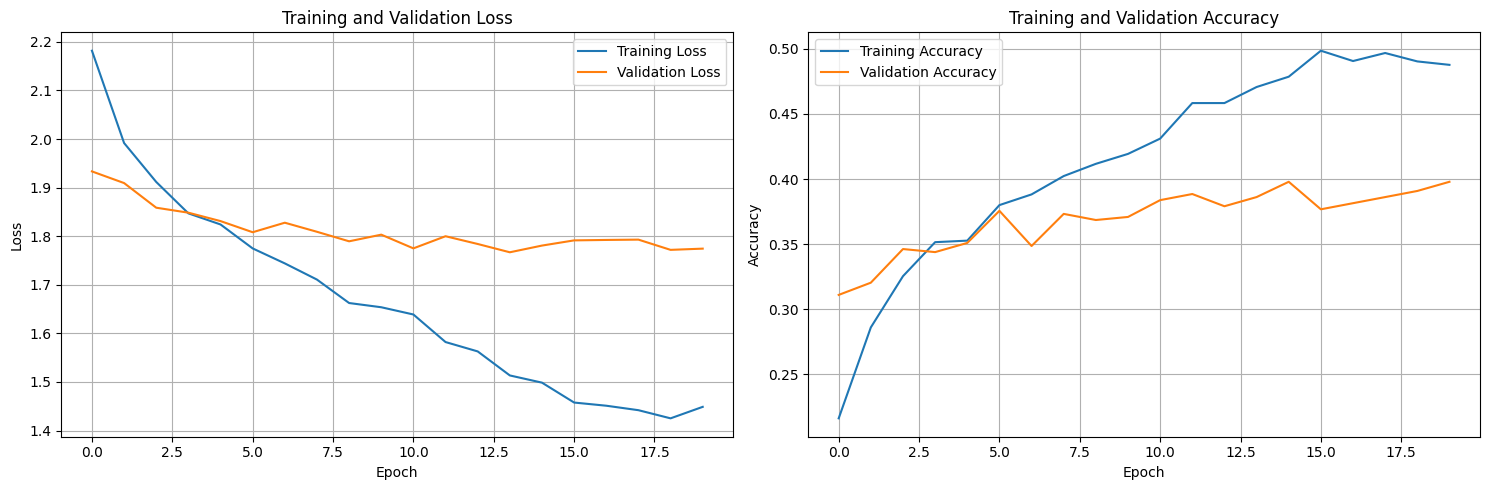


Final evaluation on validation set:


Testing: 100%|██████████| 107/107 [00:59<00:00,  1.80it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.60      0.51        72
           1       0.42      0.31      0.35        81
           2       0.39      0.30      0.34        96
           3       0.44      0.47      0.46        89
           4       0.47      0.51      0.49        88
           5       0.25      0.20      0.22        90
           6       0.29      0.27      0.28        83
           7       0.54      0.56      0.55        89
           8       0.39      0.47      0.42        87
           9       0.28      0.31      0.30        77

    accuracy                           0.40       852
   macro avg       0.39      0.40      0.39       852
weighted avg       0.39      0.40      0.39       852



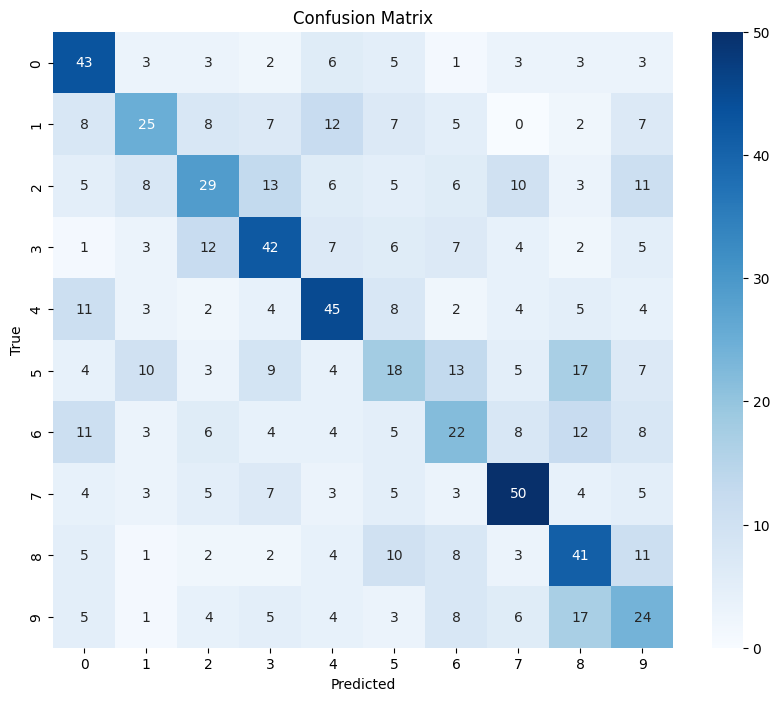

Validation accuracy: 0.3979
Model saved to video_classifier_frozen_conv.pth


In [ ]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gc 

# file paths
mp4_directory = "archive/downsampled_data"
json_file_path = "archive/downsampled_annotations.json"

# parameters from your original model
target_resolution = (112, 80)  # reduced resolution
num_frames = 16 
batch_size = 8  


# basic block for Resnet
class BasicBlock3D(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv3d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm3d(planes)
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# resnet 3d model
class ResNet3D(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        )

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=(1, 2, 2))
        self.layer3 = self._make_layer(block, 256, layers[2], stride=(1, 2, 2))
        self.layer4 = self._make_layer(block, 512, layers[3], stride=(1, 2, 2))

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv3d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.stem(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def r3d_18(pretrained=False, pretrained_path=None, num_classes=400, **kwargs):
    model = ResNet3D(BasicBlock3D, [2, 2, 2, 2], num_classes=num_classes, **kwargs)
    
    if pretrained and pretrained_path:
        try:
            pretrained_dict = torch.load(pretrained_path, map_location=torch.device('cpu'))
            model.load_state_dict(pretrained_dict)
            print(f"Successfully loaded pre-trained weights from: {pretrained_path}")
        except FileNotFoundError:
            print(f"Error: Pre-trained weights file not found at {pretrained_path}")
        except RuntimeError as e:
            print(f"Error loading state dict: {e}")
            print("Please investigate the model architecture to ensure it matches the weights.")
    
    return model

# video dataset class
class VideoDataset(Dataset):
    """Custom dataset for video classification that loads videos on-the-fly"""
    
    def __init__(self, video_paths, labels, num_frames=16, target_resolution=(112, 80), transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.target_resolution = target_resolution
        self.transform = transform
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        # extract frames from video
        frames = self.extract_video_frames(video_path)
        
        # if frames could not be extracted, return a dummy tensor with zeros
        if frames is None:
            dummy_frames = np.zeros((self.num_frames, self.target_resolution[1], self.target_resolution[0], 3), dtype=np.uint8)
            frames_tensor = torch.tensor(dummy_frames, dtype=torch.float32).permute(3, 0, 1, 2) / 255.0
            return frames_tensor, label
        
        # convert to tensor [C, D, H, W]
        frames_tensor = torch.tensor(np.array(frames), dtype=torch.float32).permute(3, 0, 1, 2) / 255.0
        
        # apply any transformations if specified
        if self.transform:
            frames_tensor = self.transform(frames_tensor)
        
        return frames_tensor, label
    
    def extract_video_frames(self, video_path, max_frames=None):
        """Extract frames from a video file"""
        if max_frames is None:
            max_frames = self.num_frames
            
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error opening video {video_path}")
                return None
            
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames == 0:
                print(f"Error: video {video_path} has zero frames")
                return None
                
            # adjust number of frames to extract based on actual video length
            num_frames_to_extract = min(max_frames, total_frames)
            frame_indices = np.linspace(0, total_frames - 1, num_frames_to_extract, dtype=int)
            
            for i in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret:
                    print(f"Error: Could not read frame {i} from {video_path}")
                    cap.release()
                    return None
                
                # resize frame to match the pretrained model's expected input size
                frame = cv2.resize(frame, self.target_resolution)
                frames.append(frame)
                
            cap.release()
            return frames
            
        except Exception as e:
            print(f"Exception processing {video_path}: {e}")
            return None

# load data function
def prepare_data():
    """Load annotations and prepare paths and labels for creating datasets"""
    try:
        with open(json_file_path, "r") as f:
            annotations = json.load(f)
    except Exception as e:
        print(f"Error loading annotations: {e}")
        return None, None, None
    
    video_paths = []
    labels = []
    video_ids = []
    
    print(f"Processing {len(annotations)} video annotations...")
    
    for video_id, label in annotations.items():
        video_path = os.path.join(mp4_directory, video_id + ".mp4")
        if os.path.exists(video_path):
            video_paths.append(video_path)
            labels.append(label)
            video_ids.append(video_id)
    
    # get class distribution
    unique_classes, counts = np.unique(labels, return_counts=True)
    print("Class distribution:")
    for cls, count in zip(unique_classes, counts):
        print(f"Class {cls}: {count} samples")
    
    return video_paths, labels, video_ids

# transfer learning model
class TransferLearningVideoClassifier(nn.Module):
    def __init__(self, base_model, num_classes=10):
        super(TransferLearningVideoClassifier, self).__init__()
        
        # use the base model as feature extractor - frozen convolutional layers
        self.base_model = base_model
        
        # get the feature dimension from the base model
        in_features = self.base_model.fc.in_features
        
        # replace the final fully-connected layer
        self.base_model.fc = nn.Identity()  # remove the original fc layer
        
        # create a more robust classifier with dropout to prevent overfitting
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),  # batch normalization helps with training stability
            nn.ReLU(),
            nn.Dropout(0.5),      # 50% dropout to prevent overfitting
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        # freeze ALL layers in the base model
        for param in self.base_model.parameters():
            param.requires_grad = False
        
    
    def forward(self, x):
        # extract features with frozen base model
        features = self.base_model(x)
        # pass through our trainable classifier
        return self.classifier(features)

# training function for classifier only
def train_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001):
    """Train the model with classifier-only fine-tuning"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    # get only the classifier parameters that require gradients
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print(f"Training parameter: {name}")
    
    # using a slightly higher learning rate since we're only training the classifier
    optimizer = optim.Adam(params_to_update, lr=learning_rate)
    
    # cosine annealing because it works well for fine tuning
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # for tracking metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Clear GPU cache periodically
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # calculate training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # validation phase
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # learning rate scheduler step
        scheduler.step()
        
        # save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Force garbage collection
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_accuracy:.4f}")
    
    # plot training curves
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return model

# evaluation function
def evaluate_model(model, data_loader, criterion=None, device=None):
    """Evaluate model on the provided data loader"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # free memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

# testing function
def test_model_detailed(model, test_loader, class_names=None):
    """Perform detailed testing with metrics and confusion matrix"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            
            # free memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    #calculate and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # generate classification report
    if class_names is None:
        class_names = [str(i) for i in range(len(np.unique(all_labels)))]
    
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # return overall accuracy
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    return accuracy

# visualization function
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation metrics"""
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.savefig('training_curves.png')
    plt.tight_layout()
    plt.show()


# saves model
def save_model(model, filename='video_classifier_transfer_learning.pth'):
    """Save the trained model to disk"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': str(model),
    }, filename)
    print(f"Model saved to {filename}")


# adding regularization
def add_weight_decay(model, weight_decay=1e-5):
    """Add L2 weight decay to Adam optimizer"""
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if len(param.shape) > 1:  # apply to weights only
                decay.append(param)
            else:
                no_decay.append(param)
    
    return [
        {'params': decay, 'weight_decay': weight_decay},
        {'params': no_decay, 'weight_decay': 0.0}
    ]

if __name__ == "__main__":
    # setting path to pretrained weights
    pretrained_weights_path = 'r3d_18-b3b3357e.pth'
    
    #preparing data paths and laebsl
    video_paths, labels, video_ids = prepare_data()
    
    if not video_paths:
        print("Failed to prepare data. Exiting.")
        exit(1)
    
    # creates dataset
    print("Creating video dataset...")
    dataset = VideoDataset(video_paths, labels, num_frames=num_frames, target_resolution=target_resolution)
    
    # splits dataset
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    print(f"Total dataset size: {dataset_size}")
    print(f"Training set size: {train_size}")
    print(f"Validation set size: {val_size}")
    
    # creating data loaders with appropriate batch sizes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # count num classes
    num_classes = len(np.unique(labels))
    print(f"Number of classes: {num_classes}")
    
    # loads in pretrained model
    print("Loading pretrained R3D-18 model...")
    base_model = r3d_18(pretrained=True, pretrained_path=pretrained_weights_path, num_classes=400)
    
    # creating transfer learning model
    print("Creating transfer learning model with frozen convolutional layers...")
    model = TransferLearningVideoClassifier(base_model, num_classes=num_classes)
    
    # prints model acrhictecture
    print("\nModel Architecture:")
    print(model)
    
    # counting trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTrainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")
    
    # trains model
    print("\nStarting training with classifier-only fine-tuning...")
    model = train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001)
    
    #fimal eval
    print("\nFinal evaluation on validation set:")
    class_names = [str(i) for i in range(num_classes)]
    val_accuracy = test_model_detailed(model, val_loader, class_names)
    print(f"Validation accuracy: {val_accuracy:.4f}")
    
    #saves model
    save_model(model, filename='video_classifier_frozen_conv.pth')
